## MNIST Data Set

The MNIST data set consists of $70000$ images of hand written digits, $60000$ of which are typically used as labeled training examples, where the other $10000$ are used for testing your learning model on. The following picture represent a sample of some of the images.

<img src="MnistExamples.png" alt="Drawing" style="width: 500px;"/>


To access this data set, as well as view the data as an image, we will need the following packages:
 * MLDatasets [documentation](https://github.com/JuliaML/MLDatasets.jl)
 * Images, TestImages, ImageMagicIO [documentation](https://juliaimages.org/latest/)

In [13]:
import Pkg; Pkg.add("MLDatasets")
Pkg.add("TestImages")
Pkg.instantiate()
using MLDatasets, Plots, Images, TestImages

"
train_x, train_y = Fashion_MNIST.traindata()
test_x,  test_y  = Fashion_MNIST.testdata()
"

train_x, train_y = MNIST.traindata()
test_x,  test_y  = MNIST.testdata()

# Flatten the matrix input data into a vector
X = []   # Flattened 784 column vectors
Y = []   # One-hot encoding label vectors 
for i = 1:60000
    push!(X, reshape(train_x[:,:,i], 784))
    y = zeros(10)
    y[train_y[i] + 1] = 1.0
    push!(Y,y)
end
train_data = [x for x in zip(X, Y)];

# Flatten the matrix input data into a vector
X = []   # Flattened 784 column vectors
Y = []   # One-hot encoding label vectors 
for i = 1:10000
    push!(X, reshape(test_x[:,:,i], 784))
    y = zeros(10)
    y[test_y[i] + 1] = 1.0
    push!(Y,y)
end
test_data = [x for x in zip(X, Y)];

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [14]:
# Fun ways to visualize images
function show_training_img(i)
    colorview(Gray, train_x[:,:,i]')
end

function show_test_img(i)
    colorview(Gray, test_x[:,:,i]')
end

show_test_img (generic function with 1 method)

## Building the Network Architecture 
For our purposes, we will build a multilayered perceptron with $L$ layers, $784$ input notes, $L-2$ hidden layers of arbitrary size, and $10$ output nodes. 

<img src="multilayerPerceptron.jpg" alt="Drawing" style="width: 450px;"/>

For $l = 2, \dots, L$, each layer $l$ in our network will have two phases, the preactivation phase $$z^l = W^la^{l-1} + b^l,$$ and postactivation phase $$a^l = \sigma(z^l).$$ The preactivation phase consists of a weighted linear combination of postactivation values in the previous layer. The postactivation values consists of passing the preactivation value through an activation function elementwise. Note $a^1 = x$, where $x$ is the current input data into our network. For our activation function, we will use the sigmoid function:

* Sigmoid Function
$$
\sigma(s) = \frac{1}{1+e^{-s}}.
$$

For our cost function, we will use the Mean Sqaure Error cost:
$$
C = C(W, b) = \frac{1}{2}\sum_{i=1}^n||a^i - y^i||^2.
$$

In [15]:
# Define sigmoid function
σ(v) = 1.0/(1.0 + exp(-v))

# Define the derivative of the sigmoid function
dσ(v) = σ(v)*(1.0 - σ(v))

# Define the cost of a given output
MSE(a, y) = (1/2)*sum((a[i] - y[i])^2 for i = 1:size(a)[1])

# Define the total cost of a dataset with respect to weights and bias
function total_MSE(W, b, labeled_data)
    cost = 0.0
    for i = 1:60000
        Z, A = forward_pass(W, b, labeled_data[i])
        cost += MSE(σ.(A[size(W)[1]]), labeled_data[i][2])
    end
    return cost/60000
end

total_MSE (generic function with 1 method)

In [16]:
# Define feedforward pass of the network 
function forward_pass(W, b, x)
    Z = [[0.0]]
    A = [x[1]]
    for i = 2:size(W)[1]
        push!(Z, W[i]*A[i-1] + b[i])
        push!(A, σ.(Z[i]))
    end
    return Z, A
end

# Define the predicted outcome of the network with a function
function predict(W, b, x)
    Z, A = forward_pass(W, b, x)
    return argmax(A[end])- 1
end

function random_train(W, b, data_set, labeled_data_set)
    i = rand(1:size(data_set)[1])
    println("Predicted Label: ", predict(W, b, data_set[i]))
    println("Actual Label: ", labeled_data_set[i])
    show_training_img(i)
end

function random_test(W, b, data_set, labeled_data_set)
    i = rand(1:size(data_set)[1])
    println("Predicted Label: ", predict(W, b, data_set[i]))
    println("Actual Label: ", labeled_data_set[i])
    show_test_img(i)
end

random_test (generic function with 1 method)

In [17]:
# Initialize your weights/bias according to a normalized distribution
# with mean = 0.0 and standard deviation 1.0
function initialize_weights(input_layer_size, hidden_layer_sizes, output_layer_size)
    W = [[0.0], randn(hidden_layer_sizes[1], input_layer_size)]
    b = [[0.0], randn(hidden_layer_sizes[1])]
    
    for i = 2:size(hidden_layer_sizes)[1]
        push!(W, randn(hidden_layer_sizes[i], hidden_layer_sizes[i-1]))
        push!(b, randn(hidden_layer_sizes[i]))
    end
    
    push!(W, randn(output_layer_size, hidden_layer_sizes[end]))
    push!(b, randn(output_layer_size))
    
    return W, b
end

initialize_weights (generic function with 1 method)

In [18]:
# Test your function
# In this example: input layer = 784x1 -> 70x1 -> 70x1 -> 10X1 = output layer
W_test, b_test = initialize_weights(784, [100], 10);

In [19]:
size(W_test[3])

(10, 100)

In [20]:
function deltas(W, b, x) 
    Z, A = forward_pass(W, b, x)
    L = size(W)[1]
    δ = Dict()
    δ[L] = (A[end] - x[2]).*dσ.(Z[end])
    for i = L-1:-1:2
        δ[i] = (W[i+1]'*δ[i+1]).*dσ.(Z[i])
    end
    return A, δ
end

deltas (generic function with 1 method)

In [21]:
function stochastic_gradient_descent(W, b, data_set, batch_size, epochs, η; show_cost = false)
    W_new = copy(W)
    b_new = copy(b)
    L = size(W)[1]
    
    if show_cost == true
        cost_points = [(0, total_MSE(W_new, b_new, data_set))]

        for j = 1:epochs
            k = rand(1:size(data_set)[1]-batch_size)
            batch = data_set[k:k+batch_size]
            for x in batch
                A, δ = deltas(W_new, b_new, x)
                for i = L:-1:2
                    W_new[i] -= (η/batch_size)*δ[i]*A[i-1]'
                    b_new[i] -= (η/batch_size)*δ[i]
                end 
            end
        
        push!(cost_points, (j, total_MSE(W_new, b_new, data_set)))
        end
        n = η
        plot(cost_points, 
            xaxis = "Epochs", 
            yaxis = "Cost",
            title = "epochs = $epochs, batch size = $batch_size, eta = $n",
            legend = false)
        
        return W_new, b_new
    else
        for j = 1:epochs
            k = rand(1:size(data_set)[1]-batch_size)
            batch = data_set[k:k+batch_size]
            for x in batch
                A, δ = deltas(W_new, b_new, x)
                for i = L:-1:2
                    W_new[i] -= (η/batch_size)*δ[i]*A[i-1]'
                    b_new[i] -= (η/batch_size)*δ[i]
                end 
            end
        end

        return W_new, b_new
    end
end

stochastic_gradient_descent (generic function with 1 method)

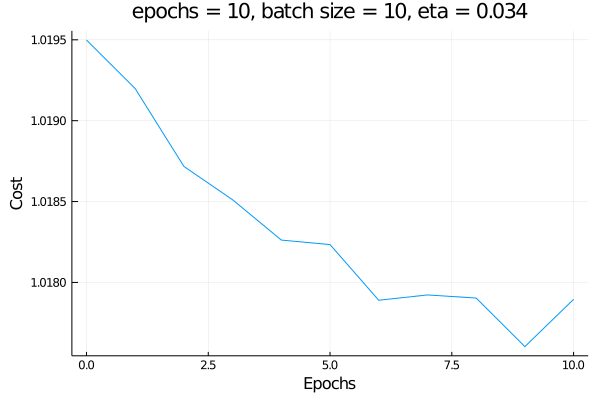

In [22]:
#W_test, b_test = initialize_weights(784, [16, 16], 10);
W1, b1 = stochastic_gradient_descent(W_test, b_test, train_data, 10, 10, 0.034, show_cost = true)
plot!()

In [ ]:
W_test, b_test = stochastic_gradient_descent(W_test, b_test, train_data, 10, 10000, 0.034)

In [23]:
random_test(W_test, b_test, test_data, test_y)

Predicted Label: 0
Actual Label: 7


28×28 reinterpret(Gray{N0f8}, ::LinearAlgebra.Adjoint{Normed{UInt8,8},Array{Normed{UInt8,8},2}}):
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)  …  Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)  …  Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)  …  Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0

All errors:
ArgumentError: Package ImageIO [82e4d734-157c-48bb-816b-45c225c6df19] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

ArgumentError: Package QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

ArgumentError: Package ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

function save does not accept keyword arguments


Errors encountered while save FileIO.Stream{FileIO.DataFormat{:PNG},IOContext{Base64.Base64EncodePipe},Nothing}(IOContext(Base64.Base64EncodePipe(IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), Base64.Buffer(UInt8[0x30, 0x50, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0x70, 0x50, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0xb0, 0x50, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0xf0, 0x50, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0x30, 0x51, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0x70, 0x51, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0xb0, 0x51, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0xf0, 0x51, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0x30, 0x52, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0x70, 0x52, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0xb0, 0x52, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0xf0, 0x52, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0x30, 0x53, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0xf0, 0x53, 0x05, 0x1e, 0x01, 0x00, 0x00, 0x00, 0x30, 0x54, 0x05, 0x1e, 0x01, 0x00, 0x0

In [ ]:
Pkg.instantiate()

In [ ]:
W_test, b_test = stochastic_gradient_descent(W_test, b_test, train_data, 10, 10000, 0.034)

In [ ]:
random_test(W_test, b_test, test_data, test_y)

In [ ]:
W_test, b_test = stochastic_gradient_descent(W_test, b_test, train_data, 10, 20000, 0.034)

In [ ]:
random_test(W_test, b_test, test_data, test_y)

In [ ]:
L = [(1, 2), (3, 4), (10, 1)]
sort!(L, by = x -> x[2])

In [ ]:
A = [1, 2, 3, 4]
B = [3, 4, 6, 7]


In [ ]:
data = [p for p in zip(A, B)]

In [ ]:
plot(data)
scatter!(data)

In [ ]:
data

In [ ]:
zip(data)

In [ ]:
for x in zip(p for p in data)
    println(x)
end

In [ ]:
data[1]

In [ ]:
X = [zip(A, B)]

In [ ]:
X

In [ ]:
d = Dict()
for x = 1:10
    d[x] = x+ 1
end

keys(d)

In [ ]:
mutable struct my_object
    a::Int64
    b::Int64
end

function add_my_object(o::my_object)
    return o.a + o.b
end

In [ ]:
m = my_object(10, 5)
add_my_object(m)